# Build a complete regional Delft-FIAT model in Brasil.

This notebook demonstrates how to set up a regional Delft-FIAT model using local assets and occupations, damage values and damage curves. As an example we will create a model for the city of Rio de Janeiro, Brasil. The relevant data is obtained from regional partners and databases. Both the data sources and the region of interest (the model domain) can be changed according to the user's wishes.

*Disclaimer: The outcomes of this model are not validated*

## **Step 0**: Import required packages
First we need to import the necessary python packages.

In [14]:
# import required packages
import os
from hydromt_fiat.fiat import FiatModel
from hydromt.log import setuplog
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import shutil

%matplotlib inline

## **Step 1a**: Configure - initialization
The first step is to set up the configuration needed to initialize the FIAT model. Begin by specifying where to save the model with the following parameters:
- `model_root`: the path to a folder where the model should be saved in
- `model_name`: the name of the model

In [15]:
model_root = "FIAT_database"  # where to save the FIAT model
model_name = "example/rio"  # name of the case study

We need some additional utilities, such as a data catalog telling the model where to find the data and a logger keeping track of changes to the model. Specifying these, the parameters below don't need to be altered.
- `model_folder`: the full path to the to be created model folder (`model_root` + `model_name`)
- `data_catalog`: the relative path to the HydroMT-FIAT global data catalog. Make sure the root specified in the catalog is correct
- `logger_name`: the log-file name. A logger object is also initialized below

In [16]:
model_folder = Path(model_root) / model_name  # full path to model folder
data_catalog = (
    Path(os.path.abspath("")) / "data" / "hydromt_fiat_catalog_Brasil.yml"
)  # path to data catalog relative to this notebook
logger_name = "hydromt_fiat"  # name of the logger
logger = setuplog(logger_name, log_level=10)  # setup logger

2025-02-26 08:17:46,250 - hydromt_fiat - log - INFO - HydroMT version: 0.9.4


## **Step 1b**: Configure - input files

To assign the relevant **maximum potential damages** and **vulnerability curves**, HydroMT-FIAT must know the occupancy linking of the asset in the exposure data. For setting up the regional vulnerability we need to prepare **three input files**:  

**1. Vulnerability curves**: A folder with a csv-file for each vulnerability curve or a single file with all vulnerability curves already aggregated. In this example notebook we use single files per vulnerability curve.

- The first column of each file describes the **waterdepth**, which should be in the same unit (meters or feet) for all curves. The second  column describes the **factor of inundation**. The file name should be the name of the damage curve.

Here an example for one vulnerability curve in meters:

|wd[m]|factor|
|---- |------|
|0.5  | 0.3  |
|0.75 | 0.7  |

**2. Vulnerability curves linking**: A csv-file which links the vulnerability curves to the occupancy type of each asset. 

- The linking csv-file must contain the following columns:
    
    1. Fiat Damage Function Name: The name of the vulnerability curve file.
    2. Exposure Link: The primary or secondary object type in the exposure data to link the vulnerability curve.
    3. Damage Type: The type of damage. This ca be structural content or any other damage the user wold like to assess. 
    4. Type: This is the occupancy type and may be the same as in the Exposure Link column but can also be a more descriptive classification. 

Here an example for four different vulnerability curves:

| FIAT Damage Function Name | Exposure Link | Damage Type | Type        |
|---------------------------|---------------|-------------|-------------|
| JRC_COMS                  | commercial    | structure   | commercial  |
| R1-BC                     | R1-B          | content     | residential |
| R1-BS                     | R1-B          | structure   | residential |

**3. Maximum potential damages and linking**: A csv-file with the max. potential damage values and the link to the occupancy of each asset
    
- The max. potential damage csv must contain the following columns:
    
    1. Exposure Link: The primary or secondary object type in the exposure data to link the max. potentia damage value
    2. Value: The damage value per square unit, here in Brazilian Real (BRL)
    3. Damage Type: The type of damage. This ca be structural content or any other damage the user wold like to assess.

Here an example for three different vulnerability curves:

| Exposure Link | Value   | Damage Type |
|---------------|---------|-------------|
| commercial    | 4026    | structure   |
| R1-B          | 2185.45 | structure   |
| R1-B          | 298.2 5 | content     |

## **Step 1c**: Configure - model setup
Next we need to set up the sptial boundaries, or domain, of the model.

A useful tool for this is http://geojson.io. Here you can draw a polygon on the map and export it to a geojson file, or copy the GeoJSON description directly into the `area_of_interest` parameter. In this example, we load in a GeoJSON file with our model domain.

In [28]:
domain_fn = Path("./data/region/Riodejaneiro.geojson")
region = gpd.read_file(domain_fn)

Next, we need to specify properties of the various dataset. For the vulnerability and exposure data HydroMT-FIAT needs the names and unit of the datasets. The names should correspond to the names (keys) in the data catalog. Should you wish to use different data sources, *make sure to update the data catalog*. For the output data, we need to specify the output file names and where to store them. The parameter names below are parsed by the model builder, so they should not be changed.

**Vulnerability**
- `vulnerability_fn`: the source name of the vulnerability curve dataset as defined in the HydroMT-FIAT global data catalog. In this example, we use regional damage curves.
- `vulnerability_identifiers_and_linking_fn`: the source name of the *occupancy type-vulnerability curves* linking table.
- `unit`: the unit of the vulnerability curves. The regional curves are in meters.

**Exposure**
- `asset_locations`: the source name of the location and (optionally) geometry data of the assests for which damages will be calculated. In this example, regional footprints are used.
- `occupancy_type`: the source name of the occupancy type data to classify the assets. In this example, the regional land use data is used.
- `max_potential_damage`: the source name of the maximum potential damage values data. In this example, the regional maximum damage values are used.
- `ground_floor_height`: the height of the ground floor of all assets, in the same `unit`
- `unit`: the unit of the exposure data

**Output**
- `output_dir`: the name of the output directory
- `output_csv_name`: the name of the output CSV
- `output_vector_name`: the name of the vector output file(s)

In [18]:
### Setup vulnerability parameters ###
csv_fn = "vulnerability_curves"
vulnerability_identifiers_and_linking_fn = "vulnerability_curves_linking"
unit = "meters"

### Setup exposure parameters ###
asset_locations = "./data/assets/rio_exposure.geojson"
occupancy_type = "./data/assets/rio_exposure.geojson"
max_potential_damage = "damage_values"
linking_column = "secondary_object_type"
ground_floor_height = 0
damage_types = ["structure", "content"]
unit = "meters"

### Setup output parameters ###
output_dir = "output"
output_csv_name = "output.csv"
output_vector_name = "spatial.gpkg"

The above parameters are collected in a dictonairy to be passed to HydroMT-FIAT.

In [19]:
configuration = {
    "setup_output": {
        "output_dir": output_dir,
        "output_csv_name": output_csv_name,
        "output_vector_name": output_vector_name,
    },
    "setup_vulnerability_from_csv": {
        "csv_fn": csv_fn,
        "vulnerability_identifiers_and_linking_fn": vulnerability_identifiers_and_linking_fn,
        "unit": unit,
    },
    "setup_exposure_buildings": {
        "asset_locations": asset_locations,
        "occupancy_type": occupancy_type,
        "max_potential_damage": max_potential_damage,
        "linking_column": linking_column,
        "ground_floor_height": ground_floor_height,
        "unit": unit,
        "damage_types": damage_types,
    },
}

## **Step 2**: Initialize
In this step we initialize HydroMT-FIAT with the `model_folder`, `data_catalog`, and `logger` that we defined above.

*Note that if the `model_folder` already exists, it is deleted before initializing HydroMT-FIAT.*

In [20]:
if model_folder.exists():
    shutil.rmtree(model_folder)
fiat_model = FiatModel(
    root=model_folder, mode="w", data_libs=[data_catalog], logger=logger
)

2025-02-26 08:17:46,337 - hydromt_fiat - data_catalog - INFO - Parsing data catalog from c:\Users\rautenba\repos\hydromt_fiat\examples\data\hydromt_fiat_catalog_Brasil.yml
2025-02-26 08:17:46,344 - hydromt_fiat - data_catalog - INFO - Parsing data catalog from C:\Users\rautenba\repos\hydromt_fiat\hydromt_fiat\data\hydromt_fiat_catalog_global.yml
2025-02-26 08:17:46,358 - hydromt_fiat - log - DEBUG - Writing log messages to new file c:\Users\rautenba\repos\hydromt_fiat\examples\FIAT_database\example\rio\hydromt.log.
2025-02-26 08:17:46,360 - hydromt_fiat - model_api - INFO - Initializing fiat model from hydromt_fiat (v0.5.1).


## **Step 3**: Build
In this step we build the Delft-FIAT model. Depending on the extent of the model it can take some time to. During the building of the model, log messages display what is happening.

*Note that the model will not yet be written because of setting the write argument to False.*

In [21]:
fiat_model.build(region={"geom": region}, opt=configuration, write=False)

2025-02-26 08:17:46,376 - hydromt_fiat - model_api - INFO - setup_region.region: {'geom':                                             geometry
0  POLYGON ((-43.36187 -22.85078, -43.36282 -22.8...}
2025-02-26 08:17:46,380 - hydromt_fiat - basin_mask - DEBUG - Parsed region (kind=geom): {'geom': 'GeoDataFrame [-43.36422181 -22.85605415 -43.35850153 -22.85057628] (crs = EPSG:4326)'}
2025-02-26 08:17:46,390 - hydromt_fiat - model_api - INFO - setup_output.output_dir: output
2025-02-26 08:17:46,391 - hydromt_fiat - model_api - INFO - setup_output.output_csv_name: output.csv
2025-02-26 08:17:46,392 - hydromt_fiat - model_api - INFO - setup_output.output_vector_name: spatial.gpkg
2025-02-26 08:17:46,393 - hydromt_fiat - model_api - INFO - setup_output.output_single_file: False
2025-02-26 08:17:46,395 - hydromt_fiat - model_api - ERROR - Default config file not found at C:\Users\rautenba\repos\hydromt_fiat\hydromt_fiat\data\fiat\settings.toml
2025-02-26 08:17:46,396 - hydromt_fiat - model_api 

## **Step 4a**: Inspect model
We now inspect the resulting exposure data and vulnerability curves that will be saved in the `fiat_model`.

### Exposure data
In the map below, the region and secondary_object_type of the exposure objects are plotted. You can zoom in and see whether the data makes sense, perhaps using Google maps and/or streetview to validate the occupancy types.

*Note: In Delft-FIAT, exposure is defined with object footprints, lines or centroids. In this example we are only using the buildings extracted from the OSM data. This means we are not going to look into, e.g., farmland, roads, etc. but that is possible with Delft-FIAT.*

In [22]:
# Get the geodataframe with exposure data
gdf = fiat_model.exposure.get_full_gdf(fiat_model.exposure.exposure_db)

# Plot the region and the secondary_object_types of the exposure data
m = region.explore(name="Region", style_kwds={"color": "black", "fill": False})
m = gdf.explore(m=m, column="secondary_object_type", name="Exposure types")
m

### Maximum potential damage values
The next thing we inspect are the maximum potential damage values. Each of these buildings has a maximum potential damage that can be inflicted by a flood, which is associated with structural damages (e.g., to the walls) or damage to contents (e.g., to the furniture).

The maximum structural potential damage of a building is associated with the construction costs, the size of the building and the depreciated value of the building after the flood. For an accurate flood damage assessment this information is required at the building level. However, often this is not available. Therefore, the buildings are usually classified based on their material and usage type, and assigned a generalized maximum potential damage per m<sup>2</sup> per class.

In this example, the maximum potential damage values per m<sup>2</sup> from a local entitiy. Vulnerability curves are taken from a regional study.

In this case the maximum potential damage is in Brazilian Real 2024. By multiplying the maximum potential damage values per m<sup>2</sup> with the area of the building footprints, we derive the maximum potential structure damage value for each of our exposure assets. You can see this in the map below.

In [23]:
gdf.explore(column="max_damage_content")

### Vulnerability curves
A flooding typically does not cause maximum damage to a structure. This is accounted for by the damage fraction, quantifying the damage to a structure relative to the maximum potential damage. A damage cuvre, or vulnerability curve, then relates the water depth (quantifying the flood severity) to the damage fraction. The shape of the damage curve differs for each occupancy type. These two datasets are linked through the vulnerability linking table. If the ground floor of a building is raised (by an amount given by `ground_floor_height`), the water depth is reduced with the ground_flht.

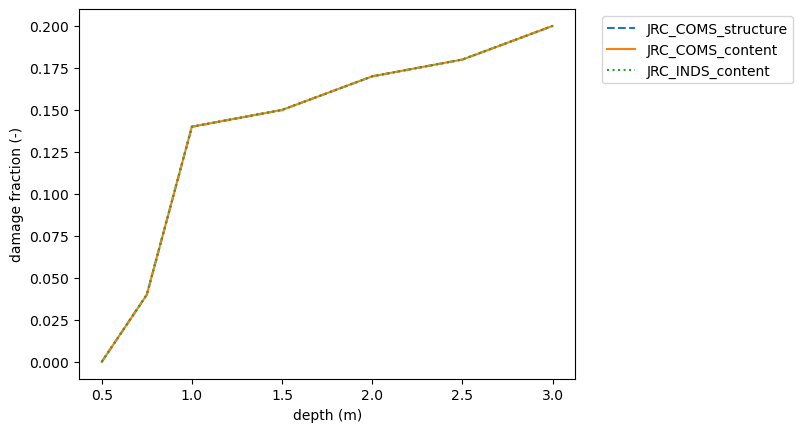

In [24]:
# Get the range of (possible) water depths
water_depths = fiat_model.vulnerability.hazard_values
# Plot damage curves for some occupancy types
line_styles = ["--", "-", ":"]
for function_name, ls in zip(fiat_model.vulnerability.functions.keys(), line_styles):
    dmg = [float(i) for i in fiat_model.vulnerability.functions[function_name]]
    plt.plot(water_depths, dmg, label=function_name, ls=ls)
plt.xlabel("depth (m)")
plt.ylabel("damage fraction (-)")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

## **Step 5**: Write a model
In this final step, the FIAT model is written to the `model_folder` in the folder structure that is required for Delft-FIAT.

In [25]:
fiat_model.write()

2025-02-26 08:17:47,321 - hydromt_fiat - fiat - INFO - Updating all data objects...
2025-02-26 08:17:47,324 - hydromt_fiat - model_api - WARNING - Replacing geom: region
2025-02-26 08:17:47,325 - hydromt_fiat - fiat - INFO - Writing model data to c:\Users\rautenba\repos\hydromt_fiat\examples\FIAT_database\example\rio
2025-02-26 08:17:47,419 - hydromt_fiat - model_api - DEBUG - Writing file geoms/region.geojson
2025-02-26 08:17:47,429 - hydromt_fiat - fiat - INFO - Writing model exposure table file to exposure/exposure.csv.
2025-02-26 08:17:47,437 - hydromt_fiat - fiat - INFO - Writing model vulnerability_curves table file to vulnerability/vulnerability_curves.csv.
2025-02-26 08:17:47,442 - hydromt_fiat - fiat - INFO - Writing model vulnerability_identifiers table file to vulnerability/vulnerability_identifiers.csv.
2025-02-26 08:17:47,445 - hydromt_fiat - model_api - INFO - Writing model config to c:\Users\rautenba\repos\hydromt_fiat\examples\FIAT_database\example\rio\settings.toml


## **Step 6**: Read a model
First initialize a new model instance in read mode in the correct folder to read in an already configured model

In [26]:
fiat_model_new = FiatModel(
    root=model_folder, mode="r", data_libs=[data_catalog], logger=logger
)
fiat_model_new.read()

2025-02-26 08:17:47,468 - hydromt_fiat - data_catalog - INFO - Parsing data catalog from c:\Users\rautenba\repos\hydromt_fiat\examples\data\hydromt_fiat_catalog_Brasil.yml
2025-02-26 08:17:47,476 - hydromt_fiat - data_catalog - INFO - Parsing data catalog from C:\Users\rautenba\repos\hydromt_fiat\hydromt_fiat\data\hydromt_fiat_catalog_global.yml
2025-02-26 08:17:47,486 - hydromt_fiat - log - DEBUG - Appending log messages to file c:\Users\rautenba\repos\hydromt_fiat\examples\FIAT_database\example\rio\hydromt.log.
2025-02-26 08:17:47,487 - hydromt_fiat - model_api - INFO - Initializing fiat model from hydromt_fiat (v0.5.1).
2025-02-26 08:17:47,490 - hydromt_fiat - fiat - INFO - Reading model data from c:\Users\rautenba\repos\hydromt_fiat\examples\FIAT_database\example\rio
2025-02-26 08:17:47,492 - hydromt_fiat - model_api - DEBUG - User defined config read from c:\Users\rautenba\repos\hydromt_fiat\examples\FIAT_database\example\rio\settings.toml
2025-02-26 08:17:47,493 - hydromt_fiat - 